# Изучение полносвязной НС в PyTorch

<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1k5ih-FSbCTuErwBHHi3J3uCN1q4fRzFI) -->

## Импорт torch

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [3]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    
    


In [4]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.1
Using device: cpu
default data type: torch.float32
available number of workers: 4


# Полносвязная нейронная сеть

## Набор данных

Попробуем построить наиболее простую полносвязную нейронную сеть. Сеть будет состоять из нескольких полносвязных слоев.
Для внутренних слоев мы используем функции активации `relu`. Для оконечного слоя мы будем использовать функцию `softmax`.

![MLP](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSy34_CeT3sV3jpkCm7GqZWSqfbdapSUaAQ2A&usqp=CAU)

Для исследований указанной нейронной сети возьмем набор данных `MNIST`. Этот набор данных представляет собой черно-белые изображения рукописных цифр ($0–9$).
Набор данных был собран Яном Лекуном и протестирован в период разработки архитектуры `LeNet`. Однако тут мы попробуем решить задачу классификации цифр при помощи полносвязной архитектуры.

Для этого возьмем набор данных `MNIST` из библиотеки `torchvision.datasets`.

Важно понимать специфику этой операции.

Во-первых, мы отдельно загрузим тренировочный и отдельно тестовый наборы данных.

Во-вторых, при загрузке наборов данных необходимо определиться с набором преобразований для наших данных. Минимальное преобразование, которое необходимо произвести, — это преобразовать входные данные в тензор. В нашем случае мы также проведем преобразование входного изображения в вектор. Изображения в наборе данных имеют размер $28\times 28$, это значит, что в результате преобразований будет тензор, имеющий $28\cdot 28 = 784$ значения. Также проведем нормализацию входного тензора в диапазон $[0, 1]$. Мы знаем, что входные данные представляют собой бинарное изображение, где максимальное значение — `255`, а минимальное — `0`. Поэтому нормировку мы проведем при помощи деления на `255`.

`PyTorch` позволяет производить преобразования входных данных при помощи класса `transforms.Compose`. Объект этого класса позволяет описывать последовательность преобразований над входными данными, указывая их в виде списка.

Объект transform класса transforms.Compose будет передан в соответствующем аргументе в загрузчик данных нашего датасета.

Отметим, что в нашем случае имеется необходимость в скачивании набора данных со стороннего ресурса, пока оригинальный не работает. Поэтому тут мы используем также и сторонний загрузчик данных `MNISTDataset` и набор данных в директории `dataset`.

Оригинальный набор данных можно также найти тут: [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/).

Для этого набора данных можно было бы использовать следующий код для загрузки из набора данных torchvision:
```python
transform=transforms.Compose([
                           transforms.ToTensor()
                            ])

train = torchvision.datasets.MNIST('', 
                                   train=True, 
                                   download=True,
                                   transform  = transform)

test  = torchvision.datasets.MNIST('', 
                                   train=False, 
                                   download=True,
                                   transform =transform)


```

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
print(*[x for x in os.listdir(os.getcwd()) if x.endswith('.py')])


dataset_loader.py


In [7]:
import torchvision
from dataset_loader import MNISTDataset

In [8]:
transform_ = lambda x: x.flatten() / 255.0
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transform_,
                            ])

In [9]:
# import ssl

# ssl._create_default_https_context = ssl._create_stdlib_context

In [10]:

# target_transform = lambda x: torch.zeros(10).scatter_(0, x, value=1)

train = MNISTDataset(images_filepath="dataset/train-images.idx3-ubyte", 
                             labels_filepath="dataset/train-labels.idx1-ubyte",
                             transform=transform)

test = MNISTDataset(images_filepath="dataset/t10k-images.idx3-ubyte",
                         labels_filepath="dataset/t10k-labels.idx1-ubyte",
                         transform=transform)

Полученный набор данных представляет собой итерируемый объект. Доступ к отдельным элементам такого датасета может быть получен как для списка. Каждый элемент представляет собой изображение (в нашем случае — вектор) и его метку.

In [11]:
train[0][0].shape, train[0][1].shape

(torch.Size([784]), torch.Size([]))

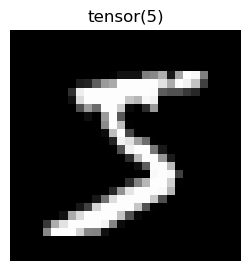

In [12]:
WIDTH = 28
HEIGH = 28
plt.figure(figsize=(3,3)); plt.imshow(train[0][0].view(WIDTH,HEIGH), cmap='gray');
plt.title(train[0][1])
plt.axis('off')
plt.show()

Отметим, что также можно скачать набор данных в ручную, например с рессурсов `PyTorch` как:
```python
from pathlib import Path
import requests
import pickle
import gzip

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)


with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
```
в результате будут созданы массивы `x_train, y_train, x_valid, y_valid` в формате `numpy`


https://pytorch.org/tutorials/beginner/nn_tutorial.html
https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

Соотвественно можно узнать размер выборок

In [13]:
len(train), len(test)

(60000, 10000)

После загрузки изображений в формате `pytorch` необходимо автоматизировать генерацию пакетов, по которым будет производиться обучение, то есть батчей. Желательно производить загрузку батчей динамически/стохастически. Другими словами, во время каждой эпохи обучения мы будем вызывать от необходимое количество таких батчей, каждый из которых будет представлять собой заданное количество примеров входных данных, выбранных случайно из последовательности.

Для осуществления указанного кода воспользуемся утилитой `DataLoader` из `torch.utils.data`. Пример реализации показан ниже

In [14]:
BATCH_SIZE = 64

trainloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

testloader  = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

> Отметим, что объект типа [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
поддерживает асинхронную загрузку и расширение данных в отдельных рабочих подпроцессах, которые называются `workers`. По умолчанию для `DataLoader` установлено значение `num_workers=0`, что означает, что загрузка данных является синхронной и
выполняется в главном процессе. В результате главный процесс обучения должен ждать, пока данные будут доступны, чтобы продолжить выполнение.<br>
Установка `num_workers > 0` включает асинхронную загрузку данных и перекрытие между обучением и загрузкой данных. Значение `num_workers` следует настраивать в зависимости от рабочей нагрузки, `CPU`, `GPU` и расположения тренировочных данных.<br>
Также `DataLoader` принимает аргумент `pin_memory`, который по умолчанию равен `False`. При использовании `GPU` лучше установить `pin_memory=True`, это даст указание `DataLoader` использовать периферийную память и обеспечивает более быстрое и асинхронное
копирование памяти с хоста на `GPU`.
 

Объект, порождаемый `DataLoader`, является итерируемым. Получим случайный батч из этого объекта

In [15]:
x,y  = next(iter(trainloader))
print('x = ',x)

print('y = ',y)

x =  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
y =  tensor([1, 2, 8, 5, 2, 6, 9, 9, 9, 4, 0, 3, 9, 9, 5, 6, 7, 8, 8, 9, 2, 6, 9, 3,
        0, 5, 0, 7, 6, 1, 2, 0, 7, 4, 6, 0, 6, 9, 7, 0, 7, 3, 2, 5, 9, 0, 4, 8,
        3, 6, 4, 0, 3, 2, 6, 6, 3, 2, 2, 3, 6, 7, 8, 4])


Проверим размер каждого батча

In [16]:
images, _ =  next(iter(trainloader))
images.shape

torch.Size([64, 784])

Число батчей заданного размера можно узнать так, как это показано ниже

In [17]:
len(trainloader), len(testloader), 

(938, 157)

Проведем визуализацию батча. Для этого в `torchvision` предусмотрена специальная функция `make_grid`.

Обратите внимание на порядок операций в примере с визуализацией. Сначала производится преобразование размеров батча. Из размеров $[64, 784]$, означающих $64$ вектора, каждый по $784$ значения, мы получаем 64 изображения, каждое размером $28\times 28$.\
Однако также мы добавляем дополнительную пустую размерность. То есть вместо того, чтобы получить массив $[64, 28, 28]$, мы получаем размер $[64, 1, 28, 28]$. Дополнительная размерность означает канал изображения. В нашем случае канал только $1$. Однако в более продвинутых задачах анализа изображений мы будем использовать и по $3$ канала.\
Аналогично, и в нашем случае для визуализации батч будет создан с $3$ каналами. Поскольку мы формируем изображение, где по горизонтали должно уместиться 8 изображений, то размер будет $[3, 28\cdot 8, 28\cdot 8] = [3, 224, 224]$.

Также важно отметить, что после получения батча мы проводим операцию `transpose((1, 2, 0))` — то есть каналы становятся `3`-й размерностью, а не `1`-й. Тут имеет место крайне важное различие между представлением данных в `matplotlib` и `torch`. В `matplotlib` каналы — это последняя размерность. Тогда как в `torch` каналы — это или `1`-я размерность, или `2`-я, если речь идет о наборе изображений (батче).

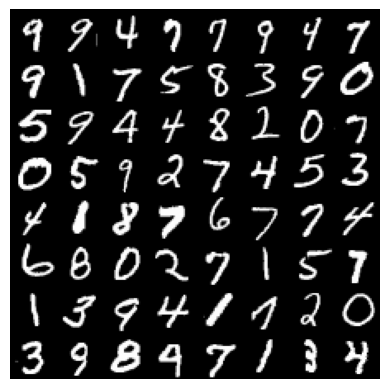

(torch.Size([64, 1, 28, 28]), torch.Size([3, 224, 224]), (224, 224, 3))

In [18]:
images = images.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = 8, padding = 0)
vis_batch = batch.numpy().transpose((1, 2, 0))
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape


### Задание

На самом деле даже для изображений таких цифр размер $28\times 28$ может показаться избыточным. Добавьте к процедуре загрузки изображений их сжатие до размера $14\times 14$

## Архитектура и ее обучение

В целом процесс описания модели в `PyTorch` и процесс ее оубчения можно бы было представить следующим орбазом.
* __Проектирование архитектуры__ (__`data understanding`__). Определите задачу __data science__, возможную архитектуру на основе количества и типов слоев (__`layers`__), типов нелинейных функций (напр. __activation function__, __regularization/normalization__, и т.д.) и связей.
* __Подготовка данных__ (__`dataset`__). Подготовьте входные и выходные данные, а также загрузчики данных для повышения эффективности.
* __Предобработка данных__ (__`transformation`__). Это может быть необходимостью (приведение типов данных или размерностей) или по крайней мере полезно для  моделей. Также на данном этапе может быть проведена некоторя подготовка данных, например фильтарция откровенно зашумленных данных или в целом представление/визуализация данных.
* __Описание модели__ (__`model`__). Определите класс для представления нейронной сети с помощью `torch.nn.Module`. Используйте предварительно созданные слои из `torch.nn` если это возможно. Используйте функциональный стиль там, где это возможно (`torch.nn.functional`).
* __Выбор функции потерь__ (__`loss function`__) и __оптимизатора__(__`optimizer`__). Выберите функцию потерь, например `Cross-Entropy` для классификации или `Mean Squared Error` для регрессии. Выберите оптимизатор, например стохастический градиентный спуск `SGD`.
* __Цикл обучения__ (__`training`__). Проводите итерации обучения по пакетам (батчам) данных. То есть 1 backward на 1 батч данных. __Проход вперед__ (__`farward`__) - вычисление предсказаний модели на основе входных данных. __Обратный проход__ (__`backward`__) Вычисление градиентов и обновление весов для минимизации потерь.
* __Оценка модели__ (__`evaluation`__). После обучения оцените производительность модели на отдельном тестовом наборе данных, используя __метрики__ (<u>не значеия `loss` функции, а метрики!</u>), например: точность, прецизионность, отзыв или аналогичные метрики.
* __Рабта модели__ (__`inference`__). Используйте обученную модель для составления прогнозов на новых, неизвестных данных.

>В некотором смысле указанное описани созвучно типичному представление о Data science life cycle
<img src="https://www.analytixlabs.co.in/blog/wp-content/uploads/2020/07/image-5-25-3.jpg" width="700px">

Попробуем обучить наиболее простую архитектуру для решения задачи классификации.
Архитектуру создадим из $3$-х слоев. По некоторым рекомендациям, архитектуры с $3$-мя и более слоями являются глубокими.

Опишем архитектуру:
* на вход модели будут подаваться вектора нужного размера $784$.
* первый скрытый слой будет представлять собой матрицу размером $784 \times 64$.
* второй скрытый слой будет представлять собой квадратную матрицу $64 \times 64$.
* третий слой будет выходным — он будет иметь $64$ значения на входе и $10$ на выходе, то есть по числу классов.
* скрытые слои будут иметь функцию активации `relu` (напомним, что $relu(x) = max(0, x))$.
<!-- * последний слой будет иметь функцию активации, обозначенную тут как `log_softmax`, то есть так называемый __логит__. Этот прием является стандартным в `pytorch`. Далее мы будем использовать функцию потерь, адаптированную под этот прием. Функция имеет примерный вид:
  ```python
    log_softmax = lambda x: x - x.exp().sum(-1).log().unsqueeze(-1)
  ``` -->

Архитектуру опишем в классовом стиле. Напомним, что это означает описание класса модели, наследующего от `nn.Module`.
Класс должен иметь две обязательных функции: конструктор класса `__init__` и метод `forward`:
* конструктор класса `__init__` инициализирует (описывает) необходимые операции.
* метод `forward` обязан иметь аргумент х, который будет принимать экземпляры данных на входе. Метод задает последовательность обработки входных данных. Метод возвращает результат работы модели.
> Фактически метод  `forward` соответствует (и вызывается) в магическом методе `__call__`. Поэтому к модели можно обращаться как к функции после ее инициализации вместо вызова `.forward`.

>Обратите внимание, что функции активации в данном примере вызываются в функциональном стиле из `nn.functional` и не объявляются в конструкторе.

In [19]:
IMAGE_WIDTH = 28 
IMAGE_HEIGH = 28

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(IMAGE_WIDTH*IMAGE_HEIGH, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x  #log(softmax(x)) in loss assumed

Аналогично можно бы было задать модель как
```python
nn.Sequential(
              nn.Linear(IMAGE_WIDTH*IMAGE_HEIGH, 64),
              nn.ReLU(),
              nn.Linear(64, 64),
              nn.ReLU(),
              nn.Linear(64, 10)
             )
```

> Отметим, что модель `Sequential`, и класс `Module` в `PyTorch` - это инструменты для создания архитектур нейронных сетей.
__Ключевые отличия__:
> * __Конструктор__. Контейнер `Sequential` использует объекты-блоки (например, `nn.Conv2d`) для определения слоев, в то время как класс типа `Module` позволяет непосредственно описывать слои  в конструкторе `__init__()`  (например, `fc=nn.Linear()`).
> * __Обработка сложности__. Описание типа `Module` обеспечивает большую гибкость, позволяя создавать ветвления и архитектуры с несколькими входами/выходами. В отличие от него, `Sequential` предназначен для простых многоуровневых конфигураций.
> * __Настройка слоев__. Хотя `Module` дает более тонкий контроль ораганизации слоев, простота `Sequential` может быть полезна для быстрого создания прототипов или для случаев с линейной структурой слоев.
> * Отметим, что модули могут описываться и более сложными структурами, в которых nn.Sequential может, например опсывать типичный блок в конструкотре. __Могу быть и другие [варианты построения модулей](https://pytorch.org/docs/stable/notes/modules.html)__.  

Также важно уточнить, что в указанных структурах могут быть заданы не только полные модели, но и их [отдельные слои](https://github.com/Devinterview-io/pytorch-interview-questions?tab=readme-ov-file#process-for-implementing-custom-layers).

Проверим результат

In [20]:
model = Model()

summary(model,input_size =(1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]          50,240
            Linear-2                [-1, 1, 64]           4,160
            Linear-3                [-1, 1, 10]             650
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


В данном случае число параметров определяется очень просто, и подобную суммаризацию можно было бы проделать самостоятельно. Так как все параметры имеют формат `float32` ($4$ байта), то и размер оперделить не сложно.
Однако в случае более сложных архитектур утилита окажется полезной

In [21]:
print(f'Linear-1 {784*64+64}')
print(f'Linear-2 {64*64+64}')
print(f'Linear-3 {64*10+10}')
total_p = 784*64+64+64*64+64+64*10+10 
print(f'Total params {total_p}')
print(f'Estimated Total Size (MB): {total_p*4/1024/1024:.2f}')
 

Linear-1 50240
Linear-2 4160
Linear-3 650
Total params 55050
Estimated Total Size (MB): 0.21


Проверим работу созданной архитектуры. Для этого создадим случайный вектор с размером $1\times 784$ и загрузим его в модель.
>Обратите внимание что лучше испытывать модель в режиме `torch.no_grad()` или `torch.inference_mode()` (добавлен начиая с версии 1.9) . Иначе после вызова метода forward будет ожидаться проведение расчета ошибки и вызов метода `backward`.\
>Кроме того мы также зададим директиву `.eval()` для модели. Сейчас она нужна лишь формально. Однако, в ряде случаев, например, если вы используете `DropOut` директивы позволит использовать его в режиме тестирования - то есть по назначению.

In [22]:
test_x = torch.rand(1,784)
with torch.inference_mode():
    model.eval()
    test_res = model(test_x)
print(test_res)

tensor([[-0.1987,  0.1101, -0.0370, -0.1374,  0.0685,  0.0971,  0.0958, -0.1735,
         -0.1875, -0.1090]])


Полученный результат содержит $10$ чисел, в общем-то не говорящих ни о чем. Однако в процессе обучения мы будем требовать, чтобы правильному классу соответствовало максимальное из этих чисел. Тогда класс можно будет определить так, как это показано ниже.

In [23]:
torch.argmax(test_res)

tensor(1)

В данном случае мы имеем 0 класс. 
Кроме того напомним, что результат можно привести к софт-макс следующим образом.

In [24]:
torch.exp(test_res)

tensor([[0.8198, 1.1164, 0.9636, 0.8716, 1.0709, 1.1020, 1.1005, 0.8407, 0.8290,
         0.8968]])

Этот результат может быть интерпретирован как вероятность того или иного класса. В идеале нам бы хотелось, чтобы вероятность нужного класса была как можно ближе к $1$. При этом (и, соответственно) вероятность остальных классов должна быть как можно ближе к $0$. Также хотелось бы, чтобы не было двух классов с близким значением вероятностей. 

Создадим также функцию потерь. Тут мы будем использовать кросс-энтропию. Функцию вызовем из `nn` в виде `nn.CrossEntropyLoss()`.

<blockquote>

Вкратце, функция `softmax` имеет вид:

$$
softmax(\mathbf{x}) = \frac{e^{x_i}}{\sum_j e^{x_j}}}
$$  

Это превращает $10$-мерный вывод, где каждый элемент - неограниченное вещественное число, в распределение вероятностей по $10$ элементам. То есть все значения находятся в диапазоне от $0$ до $1$, и все они в сумме равны $1$. 

Зачем необходимо превращать данные в распределение вероятностей? Чтобы можно было использовать NLL (отрицательное логарифмическое правдоподобие) для  функции потерь, поскольку оно ожидает вероятности. `PyTorch` вычисляет NLL для одного примера следующим образом:

$$\text{NLL }(\mathbf{\hat{y}}, y) = -\log \big( \text{softmax}(\mathbf{\hat{y}})[y] \big)$$

где $\mathbf{\hat{y}}$ - это выход $\mathbb{R}^{10}$  нейронной сети, а $y$ - это метка, целое число, обозначающее класс. Потери - это отрицательный логарифм классового индекса `softmax`. Например:

$$\mathbf{\hat{y}} = [5,1,1,1,1,1,1,1,1,1,1,1]$$

$$\text{softmax }(\mathbf{\hat{y}}) = [0.8585, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157]$$.

Если бы метка была нулевого класса, потери были бы:

$$\text{NLL }(\mathbf{\hat{y}}, 0) = - \log(0.8585) = 0.153 \dots$$.

Если бы метка была пятого класса, потери были бы:

$$\text{NLL }(\mathbf{\hat{y}}, 5) = - \log(0.0157) = 4.154 \dots$$.

Таким образом, интуитивно понятно, что с увеличением выхода модели, соответствующего правильному индексу класса, значение функции потерь уменьшаются.
</blockquote>

In [25]:
criterion = nn.CrossEntropyLoss() #This criterion assume built-in `log_softmax` 

Проверим работоспособность функции потерь. Для этого подадим на один из входов результирующий тензор размером $[1 \times 10]$, тогда как на второй вход подадим ожидаемый ответ, например $1$. Ответ должен быть тензором в формате `long`. Входной тензор в формате `float`.

In [26]:
criterion(test_res, torch.ones(1).long())

tensor(2.1528)

Напомним, что если бы размер батча входной выборки был более 1 мы все равно бы получили одно значение функции потерь. Именно одно значение ошибки затем учитывается в методе обратного распростронения.

Ниже иллюстрация этого важного принципа для одного батча.

In [27]:
for x, y  in trainloader:  
    x_train,y_train = x.float(), y.long()
    break

with torch.no_grad():
    model.eval()
    test_res = model(x_train)

criterion(test_res, y_train)

tensor(2.2949)

В примерах выше  веса  моделей обновлялись вручную изменяя тензоры, содержащие обучаемые параметры, с помощью `torch.no_grad()`. Это не является большой нагрузкой для простых алгоритмов оптимизации, таких как стохастический градиентный спуск, но на практике мы часто обучаем нейронные сети, используя более сложные оптимизаторы, такие как `Adam` и `RMSProp`.  Для упрощения процедуры работы с такими алгоритмами `PyTorch` содержит пакет `optim`, предоставляющий реализации широко используемых алгоритмов оптимизации.

В нашем примере выберем оптимизатор  `Adam` и значение скорости обучения $0.005$.
В оптимизаторе нужно указать все параметры необходимые для обучения.

Напомним, что оптимизаторы могут быть выбраны для каждого набора обучаемых параметров. 
При этом могуn быть и необучяемые параметры (например, специально замороженные).

In [28]:
criterion = nn.CrossEntropyLoss() #This criterion requires `log_softmax` 
optimizer = optim.Adam(model.parameters(), lr=0.005)

Теперь запустим процесс обучения. Обучение будет длиться 5 эпох. Каждая эпоха будет включать следующие операции.
* Выгрузка батча и его преобразования.
* Получение результатов работы модели для всего батча!
* Расчет функции потерь для всего батча.
* Процедуру обратного распространения ошибки `.backward()`.
* Шаг оптимизации (`optimizer.step()`).
* Обнуление градиентов (`.zero_grad()`) для следующего батча.
* Вывод промежуточных результатов.

In [29]:
EPOCHS = 5

for epoch in range(EPOCHS): 
    loss_ = 0
    model.train()
    for x, y  in trainloader: 
        x, y = x.float(), y.long()
        output = model(x)  
        loss = criterion(output, y)  
        loss.backward()  
        optimizer.step()  
        model.zero_grad() 
    loss_ += loss.item()
    print('[epoch:%d/%d]'%(epoch,EPOCHS), 'loss val = %.4f'%(loss_/len(trainloader)) )


[epoch:0/5] loss val = 0.0002
[epoch:1/5] loss val = 0.0003
[epoch:2/5] loss val = 0.0004
[epoch:3/5] loss val = 0.0003
[epoch:4/5] loss val = 0.0001


In [30]:
output.shape, y.shape

(torch.Size([32, 10]), torch.Size([32]))

Теперь остается посчитать точность обучения. Напомним, что под этим термином подразумевается число правильных ответов, деленное на общее число ответов. То есть для каждого изображения будем сравнивать результат предсказания с его меткой. 

In [31]:
correct = 0
total   = 0

model.eval()
with torch.no_grad():
    for x, y  in testloader:
        x,y = x.float(), y.long()
        
        output = model(x.view(-1,784))
        
        for idx, y_hat in enumerate(output):
            cls_predict = torch.argmax(y_hat)
            if cls_predict == y[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 2))

Accuracy:  0.97


In [1]:
def view_classify(img, y_prob, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = y_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

### Задания

**1.** В общем случае, помимо указанной метрики, следовало бы провести замеры иных необходимых [целевых метрик](https://en.wikipedia.org/wiki/Precision_and_recall). **Однако, эта процедура предоставляется слушателию на самостоятельное решение** Каждую выбранную метрику следует проинтерпретировать!

**2.**  C целью улучшения качества работы нейронных сетей могут быть проведены эксперименты по ее регуляризации или модификации слоев. Например пуетм добавления остаточной связи к промежуточному слою. Предлагаем слушателю также реализовать такую конфигурацию слоя. 
> Отметим, что такой слой может быть реализован только в классовом описании архитектуры.

__3.__ В некоторых случаях вместо того чтобы предсказыавть единственно верный класс среди результатов работы моделей выбиают несколько с наибольшими вероятностями (т.н. `top-k`). Предлагаем реализовать такой подход для изучаемого набора данных, например для задачи `top-3`.

<details>

```python
    def calculate_topk_accuracy(y_pred, y, k = 5):
        with torch.no_grad():
            batch_size = y.shape[0]
            _, top_pred = y_pred.topk(k, 1)
            top_pred = top_pred.t()
            correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
            correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
            acc_1 = correct_1 / batch_size
            acc_k = correct_k / batch_size
        return acc_1, acc_k

```

__4.__ В некоторых случаях в реальной практике оказывается, что данные для моделей размечены с ошибками. То есть, например, пренадлежность к классу выставлена не верно. Предлагаем смоделировать эту ситуацию - заменив часть (например $1\%$ меток на случайные числа) и проверить ухудшение точности работы модели.

**5.** В настоящее время крайне популярным становится использование моделей типа трансформеры для изображений. В таких моделях изображение делится на т.н. `патчи`, которые затем компануются аналогично как в подходе `RNN` изученном ранее. Ниже показан пример того как можно скомпоновать изображение для модели типа трансформер.

Иллюстрация функционирования само модели `Visual Transformer` [приведена ниже](https://github.com/lucidrains/vit-pytorch)

<img src="https://github.com/lucidrains/vit-pytorch/raw/main/images/vit.gif" width="500px">

In [93]:
class Patchify(nn.Module):
    """
    This layers takes a batch of images as input and
    returns a batch of sequences
    
    Shape:
        input: (b, h, w, c)
        output: (b, s, d)
    """
    def __init__(self, patch_size = (4,4)):
        super().__init__()
        
        self.patch_size  = patch_size

    #---------------------------------- 
    def _flatten_pathes(self, batch):

        b, c, nh, nw, ph, pw = batch.shape
        batch = torch.permute(batch, [0, 2, 3, 4, 5, 1])
        return torch.reshape(batch, [b, nh * nw, ph * pw * c])

    #----------------------------------   
    def _patchify(self, batch):
        b, c, h, w = batch.shape
        ph, pw = self.patch_size
        nh, nw = h // ph, w // pw
        
        batch_patches = torch.reshape(batch, (b, c, nh, ph, nw, pw))
        batch_patches = torch.permute(batch_patches, (0, 1, 2, 4, 3, 5))

        return batch_patches
    
    #----------------------------------        
    def __call__(self, batch):
        batch = self._patchify(batch)
        batch = self._flatten_pathes(batch)
        return batch  

Проверим работу разработанного слоя трансформации в патчи. Также увидим как преобразовать полученные патчи в части изображения

In [94]:
patchify = Patchify()

b, c, h, w = 1,1,28,28
b, c, nh, nw, ph, pw = 1, 1, 7, 7, 4, 4

# vector 2 image
img_torch = train[0][0].reshape((b, c, h, w))

patches = patchify(img_torch)

# vectorized patches to patches of image
img_patch = patches.reshape((b, c, nh, nw, ph, pw))
img_patch.shape, patches.shape

(torch.Size([1, 1, 7, 7, 4, 4]), torch.Size([1, 49, 16]))

Визуализируем полученное попатченное изображение

torch.Size([1, 7, 7, 4, 4])


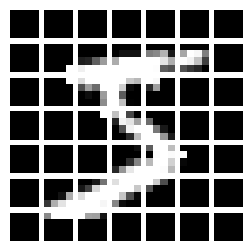

In [95]:
patch_size = (7, 7)


patches = img_patch[0]

print(patches.shape)

c, nh, nw, ph, pw = patches.shape


plt.figure(figsize=(3, 3))
for i in range(nh):
    for j in range(nw):
        plt.subplot(nh, nw, i * nw + j + 1)
        plt.imshow(patches[0, i, j].numpy(), cmap="gray")
        plt.axis("off")
plt.show()

Предлагается слушателю самостоятельно реализовать классификатор на основе реализованных ранее слоев типа трансформер

# Аугментация набора данных

## Теники аугментации в `PyTorch`

Одним из наиболее действенных приемов регуляризации обучения является расширение выборки обущающих данных. Однако, расширение вырбоки реальными примерами не всегда возможно. Поэтому возникает желание расширить выборку ["в ручную"](https://albumentations.ai/docs/introduction/image_augmentation/). То есть при помощи искусственных приемов.  Такой подход к регуляризации назвается __[Аугментация данных](https://www.d2l.ai/chapter_computer-vision/image-augmentation.html) (Data Augmentation)__. 

Цель аугментации - создать похожие, но обучающие примеры данных. Для этого используются серии случайных изменений обучающих данных. В результате аугменатция позволяет:
* Увеличить размер обучающего набора данных 
* случайные изменения обучающих примеров позволяют моделям меньше полагаться на *заложенное в ограниченной выборке смещение*, тем самым улучшая обобщающую способонсть модель./
> Например, мы можем по-разному обрезать изображение, чтобы интересующий нас объект выглядел в разных положениях, тем самым уменьшая зависимость модели от положения объекта.
* Другими словами может быть промоделирован  разброс условий получения изображений (например, можно менять яркость и цвет, чтобы уменьшить чувствительность модели к цвету). 

В `PyTorch` проблема аугментации для изображений решается при помощи модуля `transforms` из библиотеки `torchvision`. Однако, существую и внешние библиотеки аугментаций, например [albumentations](https://albumentations.ai/). Ниже показано, как работать с аугментацией данных.

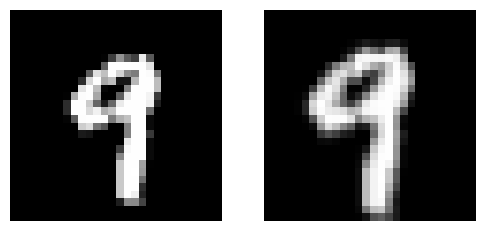

In [96]:
from PIL import Image
from torchvision import transforms 
plt.figure(figsize=(6,3))
to_pil = transforms.ToPILImage()

img = to_pil(images[0])
plt.subplot(121); plt.imshow(img, cmap = 'gray' ); plt.axis('off'); 

center_crops = transforms.Resize(size=32)(img) 
center_crops = transforms.RandomCrop(size=28)(center_crops) 

torch_image = transforms.ToTensor()(center_crops)
plt.subplot(122);  plt.imshow(torch_image[0,:,:], cmap = 'gray' ); plt.axis('off'); plt.show()


Часто одного типа аугментаций недостаточно. Важно смоделировать сразу набор факторов, влиящих на изображение. Более того важно заметить, что каждую операцию аугментации часто проводят с заданной случайностью. 

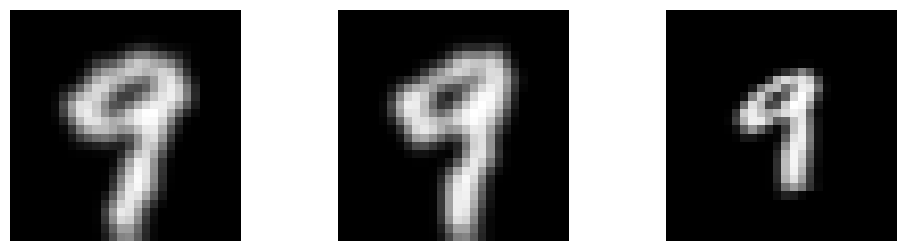

In [97]:
import torchvision.transforms as T

to_pil = T.ToPILImage()
img = to_pil(images[0])

padding = 1
kernel_size = 3

preprocess = T.Compose([
               T.ToTensor(),
               T.Resize(32),
               T.Pad(padding=padding), 
               T.CenterCrop(28),
               T.RandomRotation(degrees=10),
               T.RandomApply([T.GaussianBlur(kernel_size=kernel_size),
                              T.RandomPerspective(distortion_scale=0.6, p=0.3),],p=0.6),
                
                ])

plt.figure(figsize = (12,3))
for subplot in range(131,134):
    plt.subplot(subplot);plt.imshow(preprocess(img)[0,:,:], cmap='gray'); plt.axis('off')



Как правило аугментацию проводят (данные генерируются) в процессе работы модели (то есть оналйн). Ниже показн пример добавления показанного выше пайплайна аугментации к загручику данных.

In [98]:
transform_ = lambda x: x.flatten().abs() / 255.0
trasforms = preprocess.transforms + [transform_]
transform=transforms.Compose(trasforms)

In [99]:
train_ = MNISTDataset(images_filepath="dataset/train-images.idx3-ubyte", 
                             labels_filepath="dataset/train-labels.idx1-ubyte",
                             transform=transform)

test_ = MNISTDataset(images_filepath="dataset/t10k-images.idx3-ubyte",
                         labels_filepath="dataset/t10k-labels.idx1-ubyte",
                         transform=transform)

In [100]:
train_[0][0].shape

torch.Size([784])

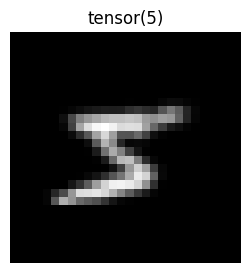

In [101]:
WIDTH = 28
HEIGH = 28
plt.figure(figsize = (3,3))
plt.imshow(train_[0][0].view(WIDTH,HEIGH).numpy(), cmap='gray');
plt.title(train_[0][1])
plt.axis('off')
plt.show()

Посмотрим на то, как теперь будет выглядеть батч данных.

In [102]:
BATCH_SIZE = 64
trainloader_ = torch.utils.data.DataLoader(train_, batch_size=BATCH_SIZE, shuffle=True)
testloader_  = torch.utils.data.DataLoader(test_, batch_size=BATCH_SIZE, shuffle=False)

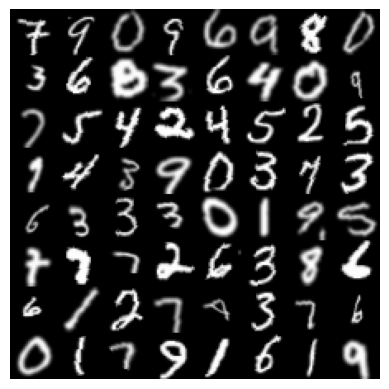

In [103]:
images, _ =  next(iter(trainloader_))
images = images.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = 8, padding = 0)
vis_batch = batch.numpy().transpose((1, 2, 0))
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()

Отметим, что помимо стандартного пакета аугменатций экосистема `PyTorch` предлагает еще два пакета для расширения этого понятия. 
*  torchvision.transforms.v2 [https://pytorch.org/vision/main/transforms.html](https://pytorch.org/vision/main/transforms.html)

* Korina - [https://kornia.github.io/ ](https://kornia.github.io/).

```python 
    import kornia

    transform = nn.Sequential(
        kornia.enhance.AdjustBrightness(0.5),
        kornia.enhance.AdjustGamma(gamma=2.),
        kornia.enhance.AdjustContrast(0.7),
    )

    images = transform(images)

```

* albumentation - [https://albumentations.ai/](https://albumentations.ai/).

```python
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    train_transform = A.Compose(
        [
            A.SmallestMaxSize(max_size=160),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.RandomCrop(height=128, width=128),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
    ]
)
```

А также ряд пакетов для аугментации данных других модальностей.

### Задания

**1.** На самом деле аугментацию редко используют на тестовой  и валидационных выборках.  Если такой подход практикуется, скорее всего это необходимо для увеличения точности тестовой оценки. Однако, аугментация на тестовой выборке должа проводиться более аккуратно, чем на тренировочной. При начальном знакомстве с предметом глубокое обучение нейронных сетей такая аугментация не рекомендуется. __Поэтому предлагаем слушателю__ разработать преобразования `transforms`  отдельно для тестовой и отдельно для тренировочной выборок.

**2.** Предлагается сравнить точность обучения моделей для задач оубчения с аугментированной и не аугментированной тренировочной выборками. 

__3.__ Одна из главных проблем, связанных с использованием машинного обучения на [непроверенных данных](https://habr.com/ru/companies/wunderfund/articles/794546/) (в продолжительном режиме работы), заключается в риске возникновения  т.н. __дрейфа модели__ (или __дрейфа данных__). Дрейфа модели - это эффект снижения производительности модели при изменении распределения данных (при долговременном изменении признаков данных) в процессе работы. Например, для изображений, камера может загрязняться, что приведет к размытию и появлению шумов типа "соль и перец" на изображениях. Или возникнит __эффект ограниченного набора данных__ - то есть в реальных данных появятся на участятся случаи, не учтенные в тренировочных данных в достаточной степени. Например, если система обучена на наборе данных, который собран в течение одного сезона (напр. года), то этот набор данных может оказаться недостаточно полным для последующих годов. Другими словами в данных появится значительная __нестационарность__. 

В целом проблема дрейфа решается путем постоянного сбора данных и их версионирования, а также путем постоянного обучения модели (неприрывного обучения). Однако, в данном случае предлагается смоделировать возможные эффекты дрейфа данных путем аугментации данных. Проверьте как это скажется на точности модели.


**4.** При обучении нейронных сетей важно не только обучение в заданных условиях, но и стабильность работы вне зависимости от внешних условий. При разработке и обучении моделей часто упускается из виду такой аспект, как безопасность и устойчивость, перед нарушителем, желающего обмануть модель. [Вы можете быть удивлены](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html), обнаружив, что добавление незаметных возмущений к изображению может привести к радикальному изменению производительности модели. Поэтому при обучении модели важно понимать ее потенциальные уезвимости. Тогда можно добавить эти уезвимости в набор аугментации при тренировки модели, чтобы повычить устойчивость  к ним. Такой подход называется `Adversarial Attack`. 

Самый простой пример `Adversarial Attack` может заключаться в добавлении к изображениям небольших шумов.  
> Отметим, что более сложная атака заключалась бы в следующем. Зная функцию потерь для модели можно подобрать шумы так, чтобы их добавление ко входным данным максимизировало бы лосс - а следовательно градиент значений, проходящих  через модель. 

Предлагается слушателю на тестовом наборе данынх добавить шумы (напри. `troch.randn` или [другие типы](https://secml.readthedocs.io/en/stable/tutorials/06-MNIST_dataset.html#Training-of-the-classifier)) и  проследить за точностью модели в зависимости от дисперсии этих шумов (то есть от т.н. `отношения сигнал-шум`).  
>  Незабывайте, что у нас изобржение нормировано в дипапзон $[0,1]$ Поэтому после добавления шумов изобржени стоит вернуть в нужный диапазон, например, при помощи `torch.clamp(perturbed_image, 0, 1)`.

__5.__ Также для оценки надежности модели можно проверить ее работы для шумов. Проверим что для обученной модели можно создать такое распределение нормального шума на входе, что ее выход будет классифицирован как заданное верное число с определенной долей уверенности.

In [181]:
from tqdm.notebook import trange

def imagine_digit(model, digit, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(BATCH_SIZE, 28, 28).reshape(BATCH_SIZE, 28*28)

            y_pred = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [182]:
DIGIT = 0

best_image, best_prob = imagine_digit(model, DIGIT)

  0%|          | 0/50000 [00:00<?, ?it/s]

Best image probability: 16.86%


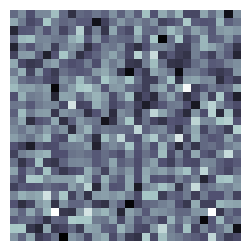

In [183]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

plt.figure(figsize=(3,3)); plt.imshow(best_image.cpu().numpy().reshape(28,28), cmap='bone')
plt.axis('off');

Предлгагаем проверить то, как аугментация данных влияет не вероятность правильной классификации выборки нормального шума.

# Анализ ошибок в наборе данных

Часто помимо того чтобы просто провести точечную оценку точности необходимо понять причины ошибок. Для этого полезно провести анализ ошибок на тестовой выборке. Как минимум для задачи классификации можно провести анализ точности по классам.

In [133]:
correct = 0
total   = 0

n_classes = 10
class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

model.eval()
with torch.no_grad():
    for x, y  in testloader:
 
        output = model(x.view(-1,784))
        cls_pred = torch.argmax(output, dim=1)
        
        for idx, (yi, y_hat) in enumerate(zip(y,cls_pred)):

            if y_hat == yi:
                class_correct[yi] += 1
            
            class_total[yi]   += 1


for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 98 %
Accuracy of     1 : 98 %
Accuracy of     2 : 96 %
Accuracy of     3 : 97 %
Accuracy of     4 : 91 %
Accuracy of     5 : 93 %
Accuracy of     6 : 98 %
Accuracy of     7 : 95 %
Accuracy of     8 : 96 %
Accuracy of     9 : 95 %


In [134]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, names_classes = np.arange(10)):
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    cm = confusion_matrix(np.asarray(labels, dtype=int), 
                          np.asarray(pred_labels, dtype=int) )
    
    cm = ConfusionMatrixDisplay(cm, display_labels=names_classes)
    
    cm.plot(values_format='d', cmap='coolwarm', ax=ax)

Тпереь соберем лейблы и предсказания в отдельные массивы.

In [135]:
labels   = []
predicts = []

model.eval()
with torch.no_grad():
    
    for x,y in testloader:

        output = model(x.view(-1,784))
        cls_pred = torch.argmax(output, dim=1)
    
        labels.append(y.tolist())
        predicts.append(cls_pred.tolist())
        
labels = sum(labels,[])
predicts = sum(predicts,[])
# labels   = torch.cat(labels, dim = 0) # make it 1d array
# predicts = torch.cat(predicts, dim = 0) # make it 1d array
    


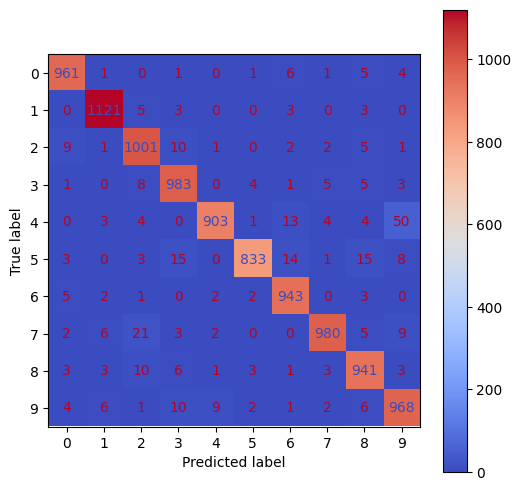

In [136]:
plot_confusion_matrix(labels, predicts)

## Задание

__1.__ Предлагается проверить scores помимо самих результатов

__2.__  Важно проверить, в каких примерах ваша модель ошибается, и убедиться, что это разумные ошибки.

Ниже приведен пример того как это сделать.
Функция `get_predictions` возвращает предсказания модели для заданного набора данных. Она возвращает входные данные (изображение), выходные данные (предсказания модели) и метки истинности. Также код ниже рассчитывает `pred_labels` - предсказанные метки класса.

In [137]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.inference_mode():

        for (x, y) in iterator:

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

images, labels, probs = get_predictions(model, testloader)

pred_labels = torch.argmax(probs, 1)

Теперь проверим полученные метки на корректность

In [138]:
corrects = torch.eq(labels, pred_labels)

Можно просмотреть все примеры предсказаний модели и сохранить в массив все примеры, в которых модель ошиблась.

Затем мы отсортируем  неправильные примеры по степени уверенности в них, причем самые уверенные будут стоять на первом месте.

In [139]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

визуализируем 25 самых неверных примеров. к каждому из них будет показ уровень уверенности и метка

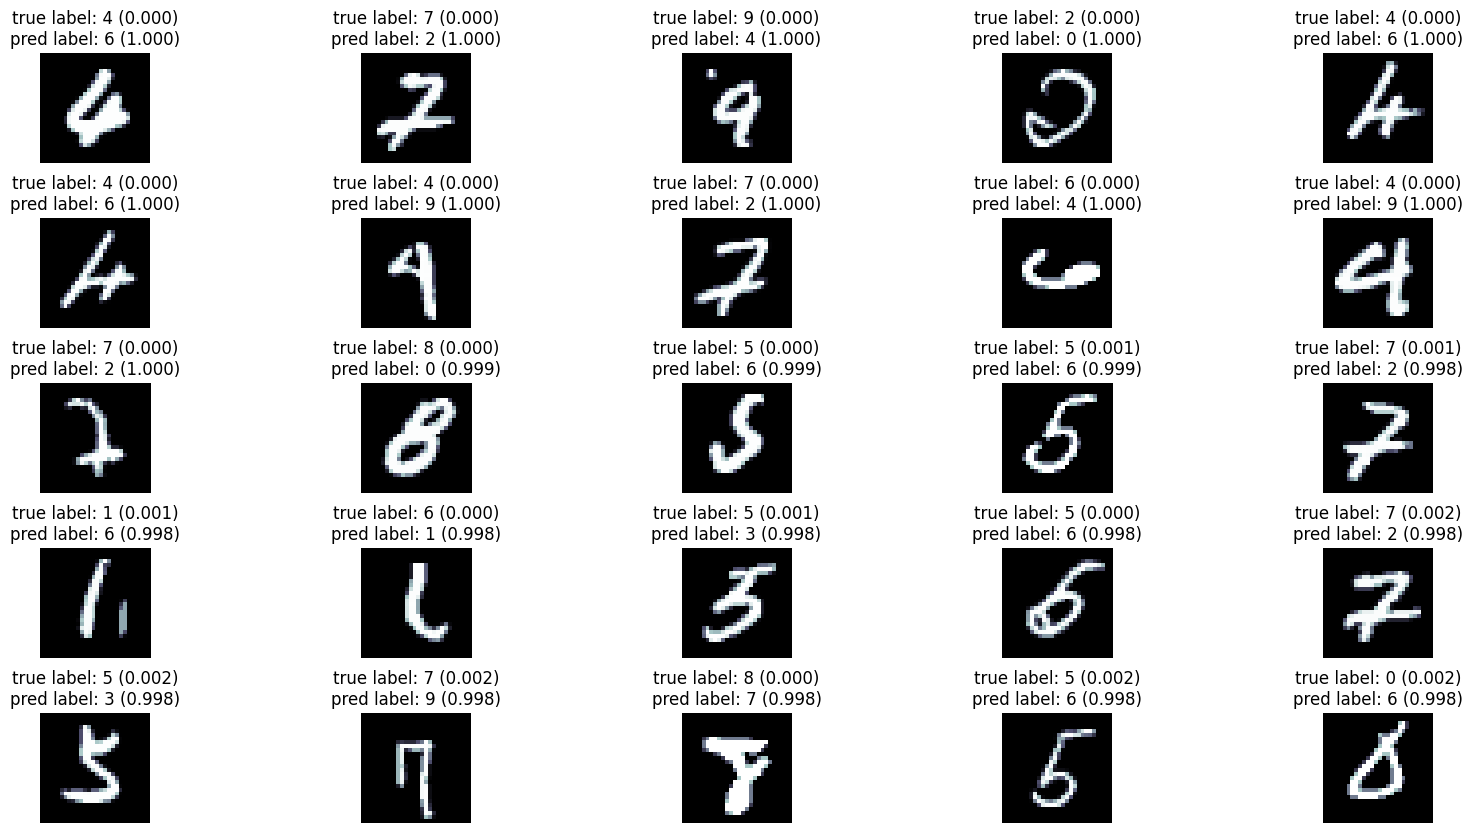

In [140]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

Многие из этих цифр неправильной формы, поэтому модели трудно справиться с ними. 

В полученных отрицательных результатах достаточно много двоек. Однако, визуализированы только 25 результатов. Предлагается провести анализ неточности по каждому классу отдельно если задан порог или число наиболее неточных результатов (аналогично анализу по каждому классу выше, но для заданного числа наиболее плохих результатов модели). Также предлагаем подумать слушателю какие методы позволили бы улучшить точность.

__3.__ Иногда полезно посмотреть как модель отображает классы в результате работы `feature extractor` (`backbone`). Этот прием используется в нескольких целях, например позволяет визуализировать отображение классов нейронной сетью. Для того чтобы такой прием релизовать необходимо иногда возвращать результат работы последнего слоя `feature extractor` отдельным выходом нейронной сети. Предлагается слушателю самостоятельно реализовать эту опцию, например при помощи объявления дополнительного аргумента `ret_fe` метода `forward`.

<details>
<summary>Click here for hint</summary>
```python
    
    IMAGE_WIDTH = 28 
    IMAGE_HEIGH = 28
    
    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(IMAGE_WIDTH*IMAGE_HEIGH, 64)
            self.fc2 = nn.Linear(64, 64)
            self.fc3 = nn.Linear(64, 10)

    
        def forward(self, x, ret_fe = False):
            x = F.relu(self.fc1(x))
            h = F.relu(self.fc2(x))
            x = self.fc3(h)

            if ret_fe:
                return x, h
            return x  #log(softmax(x)) in loss assumed
    
```

__4.__ Ниже приведен пример реализации оценки с использованием дополнительного выхода `intermediates` - выхода представления признаков моделью.

In [152]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in iterator:

            y_pred, h = model(x, ret_fe = True)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

outputs, intermediates, labels = get_representations(model,
                                                     trainloader)

  0%|          | 0/938 [00:00<?, ?it/s]

Теперь проведем визуализацию полученных результатов методом главных компонент.

In [158]:
from sklearn import decomposition
from sklearn import manifold
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [159]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

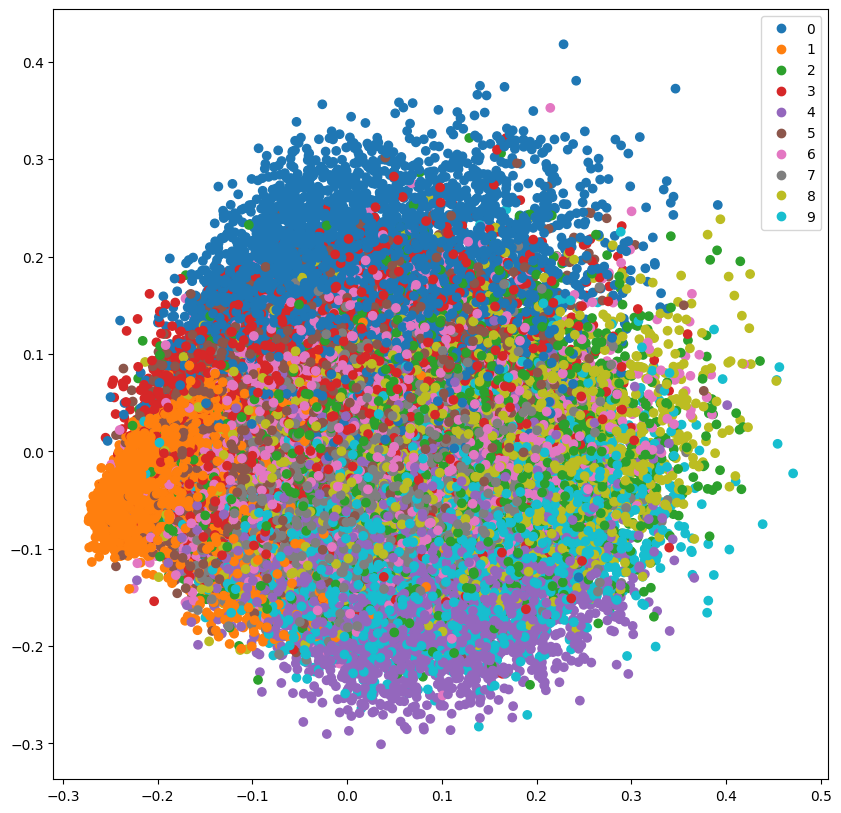

In [161]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

Ниже также показан пример визулаизации методом `t_sne`

In [162]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

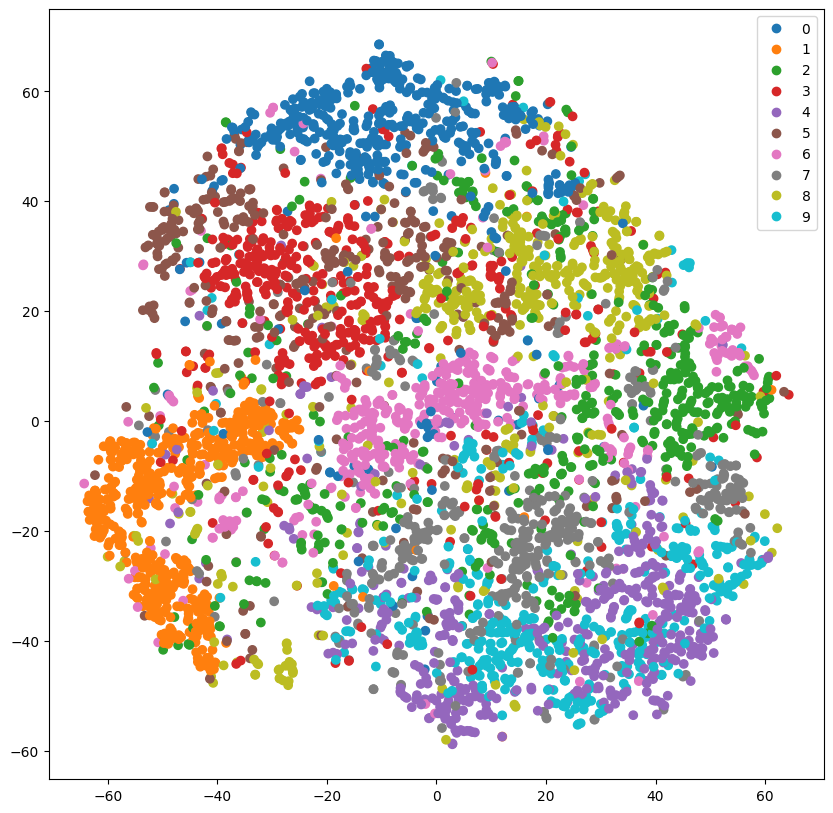

In [164]:
N_IMAGES = 5_000

intermediates_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediates_tsne_data, labels, n_images=N_IMAGES)

Предлагается проверить визуально качество сепарации данных и качество работы модели в целом в зависимости от сложности модели (например, числа слоев в ней или использования дополнительных параметров, таких как функции активации или применение регуляризаций (батч-норм, аугментация и тд).

__5.__ Предлагается провести визулаизацию выходов модели и сравнить ее с визуализацией промежуточных результатов. <br> Если допустить, что промежуточные результаты должны исходить не из последнего скрытого слоя, а из более ранних слоев, как это скажется на визуализации?